# LFW Clustering with RetinaFace + ArcFace

## 0. Setup

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import cv2
from insightface.app import FaceAnalysis
from tqdm import tqdm
import pandas as pd

## 1. Load LFW dataset

In [8]:
lfw = fetch_lfw_people(min_faces_per_person=10, resize=0.5) #min_faces_per_person=10 to ensure enough samples per identity, resize=0.5 to reduce image size for faster processing
images = lfw.images
labels = lfw.target
label_names = lfw.target_names
print(f"Images shape: {images.shape}, Identities: {len(np.unique(labels))}")

Images shape: (4324, 62, 47), Identities: 158


## 2. Initialize Face Detection + Embeddings

In [9]:
app = FaceAnalysis(name="buffalo_l")  #arcface
app.prepare(ctx_id=0, det_size=(160,160))  #app.prepare initializes the model for face detection and embedding extraction

def detect_and_embed(img):
    img_uint8 = (img * 255).astype(np.uint8) #convert image to uint8
    if len(img_uint8.shape) == 2: #if grayscale image
        img_bgr = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR) #convert to BGR
    else:
        img_bgr = img_uint8 #image is already 3-channel
    faces = app.get(img_bgr)  #app.get performs face detection
    if len(faces) == 0: #no faces detected
        return None
    return faces[0].embedding #return the embedding of the first detected face

download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:02<00:00, 94786.45KB/s]
/usr/local/lib/python3.12/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:123: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (160, 160)


## 3. Extract embeddings

In [10]:
embeddings = []
valid_labels = []
for img, lbl in tqdm(zip(images, labels), total=len(images), desc="Processing images"): #for each image and label
    emb = detect_and_embed(img) #detect face and extract embedding
    if emb is not None: #if embedding is valid, store emb & label
        embeddings.append(emb)
        valid_labels.append(lbl)

embeddings = np.stack(embeddings)
valid_labels = np.array(valid_labels)
print(f"Extracted embeddings shape: {embeddings.shape}")

Processing images: 100%|██████████| 4324/4324 [43:19<00:00,  1.66it/s]

Extracted embeddings shape: (4324, 512)


In [11]:
#save data to csv
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = valid_labels
embeddings_df.to_csv('lfw_face_embeddings.csv', index=False)
print("Embeddings and valid_labels saved to 'lfw_face_embeddings.csv'")

Embeddings and valid_labels saved to 'lfw_face_embeddings.csv'


## 4. Cluster by identity

In [105]:
filtered_labels = []
for lbl in np.unique(valid_labels):
    count = np.sum(valid_labels == lbl)
    if 5 <= count <= 10:
        filtered_labels.append(lbl)
print(f"Filtered number of identities: {len(filtered_labels)}")
print(f"Images shape: {images.shape}")
mask = np.isin(valid_labels, filtered_labels)
embeddings = embeddings[mask]
valid_labels = valid_labels[mask]

Filtered number of identities: 15
Images shape: (4324, 62, 47)


In [106]:
identity_clusters = {lbl: embeddings[valid_labels==lbl] for lbl in np.unique(valid_labels)}

In [107]:
cluster_stats = {}
for lbl, cluster in identity_clusters.items():
    centroid = cluster.mean(axis=0)
    distances = np.linalg.norm(cluster - centroid, axis=1)
    cluster_stats[label_names[lbl]] = {
        "centroid": centroid,
        "radius": distances.max(),
        "dispersion": distances.std(),
        "num_images": len(cluster)
    }

In [108]:
print(cluster_stats)

{np.str_('Bill McBride'): {'centroid': array([-3.52116972e-01, -1.57969630e+00, -1.28402126e+00, -4.67843294e-01,
       -2.27486849e-01, -8.56126606e-01, -1.36040956e-01,  2.92641576e-02,
       -6.11091144e-02,  1.43401176e-01,  1.68982863e+00,  5.24480283e-01,
        1.15540969e+00, -2.12163255e-01, -1.18455529e+00,  5.20937324e-01,
        1.75379503e+00,  4.27424014e-01, -9.08276737e-01,  1.09384608e+00,
       -1.17382741e+00,  3.71198952e-01,  1.25679386e+00, -1.36698127e-01,
        5.62061191e-01, -8.33329976e-01,  1.64640105e+00,  1.55230671e-01,
       -5.25835812e-01,  3.74314219e-01,  1.42846656e+00, -2.88646340e-01,
       -9.19396281e-01, -1.65946960e-01, -3.23573500e-01, -5.97995877e-01,
       -3.06316078e-01,  1.18831325e+00, -1.43617198e-01, -4.35761780e-01,
        9.13215935e-01, -1.05572033e+00, -1.20460284e+00, -1.91778111e+00,
        2.93419987e-01,  4.94025707e-01, -6.55265033e-01, -1.66981772e-01,
        2.91899860e-01,  7.54032969e-01, -3.38028908e-01,  8.

## 5. Intrinsic dimensionality

In [109]:
intrinsic_dim = {}
for lbl, cluster in identity_clusters.items():
    if len(cluster) < 2: #do nothing
        continue
    pca = PCA(n_components=min(len(cluster), cluster.shape[1])) #min(len cluster and 512D)
    pca.fit(cluster)
    intrinsic_dim[label_names[lbl]] = np.sum(pca.explained_variance_ratio_ > 0.01)

- pca.explanined_variance_ratio_: vector size min(n,D) contains the fraction of variance explained for each principal component.
- .>0.01: PC explains more than 1%
- sum the ones that are >0.01, and those are the intrinsic dimension

In [110]:
#intrinsic dimensions by identity
for identity, dim in intrinsic_dim.items():
    print(f"Identity: {identity}, Intrinsic Dimension: {dim}")

Identity: Bill McBride, Intrinsic Dimension: 9
Identity: Ian Thorpe, Intrinsic Dimension: 9
Identity: Jacques Rogge, Intrinsic Dimension: 9
Identity: Jason Kidd, Intrinsic Dimension: 9
Identity: Javier Solana, Intrinsic Dimension: 9
Identity: Jean-David Levitte, Intrinsic Dimension: 9
Identity: Mohammad Khatami, Intrinsic Dimension: 9
Identity: Muhammad Ali, Intrinsic Dimension: 9
Identity: Paradorn Srichaphan, Intrinsic Dimension: 9
Identity: Paul Wolfowitz, Intrinsic Dimension: 9
Identity: Richard Gere, Intrinsic Dimension: 9
Identity: Tom Cruise, Intrinsic Dimension: 9
Identity: Tom Hanks, Intrinsic Dimension: 9
Identity: Tommy Thompson, Intrinsic Dimension: 9
Identity: Walter Mondale, Intrinsic Dimension: 9


Plot with initials

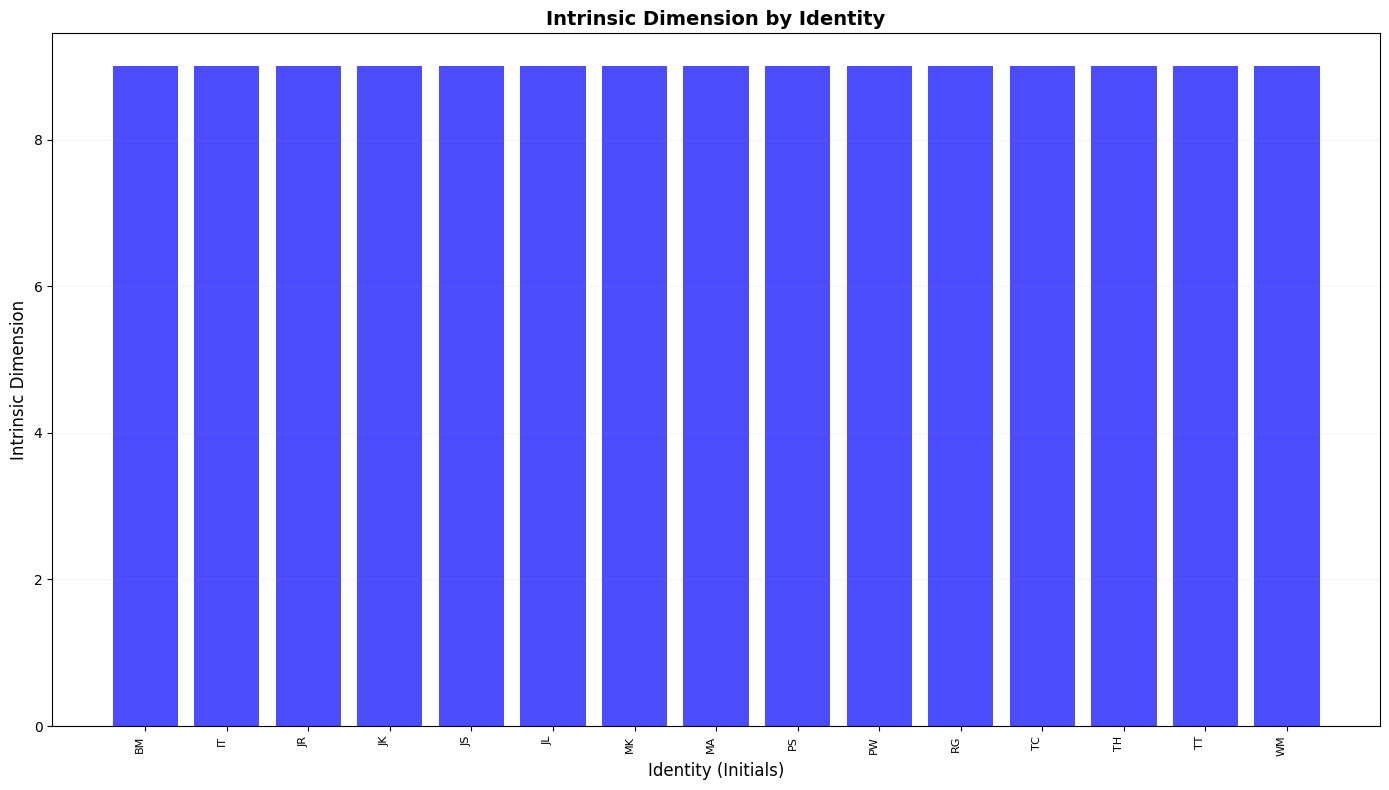

In [111]:
plt.figure(figsize=(14, 8))
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())
initials = [''.join([part[0].upper() for part in name.split()]) for name in identities]

plt.bar(initials, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity', fontsize=14, fontweight='bold')
plt.xlabel('Identity (Initials)', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

Plot by the name

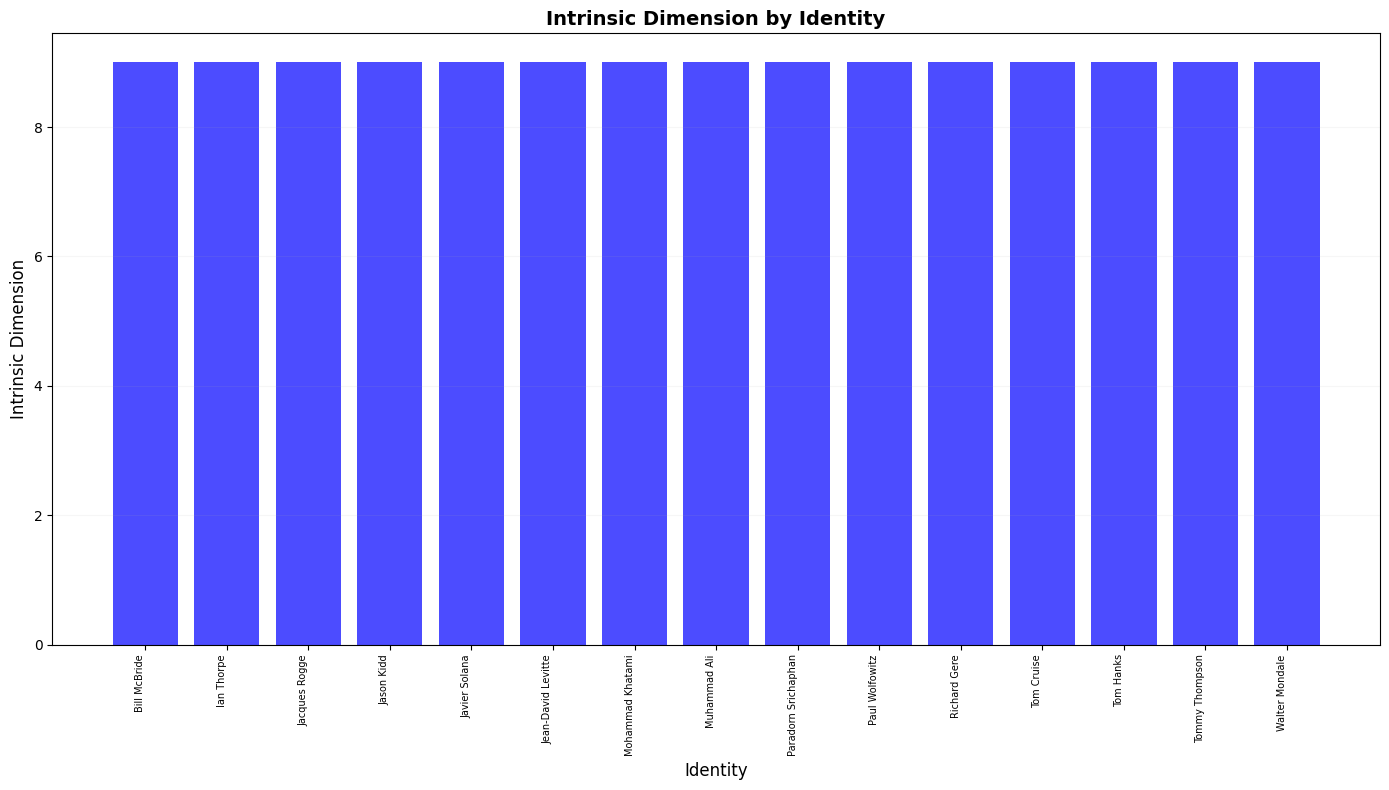

In [112]:
plt.figure(figsize=(14, 8))
identities = list(intrinsic_dim.keys())
dimensions = list(intrinsic_dim.values())

plt.bar(identities, dimensions, color='blue', alpha=0.7)
plt.title('Intrinsic Dimension by Identity', fontsize=14, fontweight='bold')
plt.xlabel('Identity', fontsize=12)
plt.ylabel('Intrinsic Dimension', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=7)
plt.grid(True, alpha=0.1, axis='y')
plt.tight_layout()
plt.show()

## 6. Visualization Clusters

Number of clusters: 15


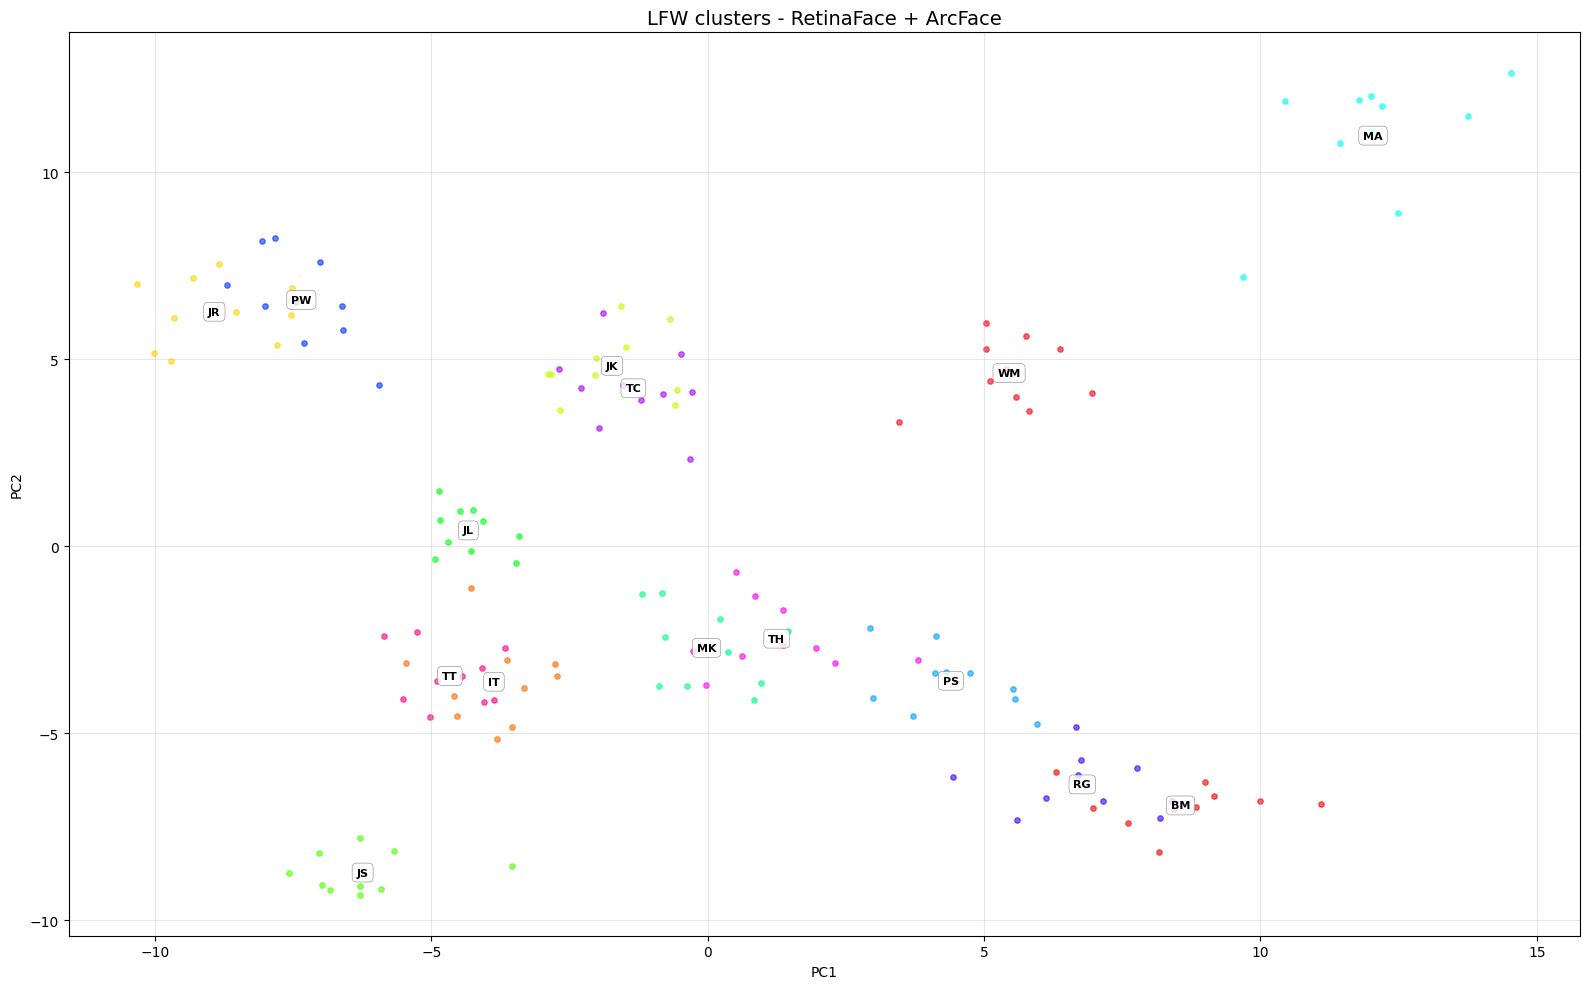

In [113]:
pca_2d = PCA(n_components=2)
emb_2d = pca_2d.fit_transform(embeddings)
centroids_2d = pca_2d.transform(np.array([cluster_stats[name]['centroid'] for name in cluster_stats.keys()]))

num_clusters = len(np.unique(valid_labels))
print(f"Number of clusters: {num_clusters}")
colors = plt.cm.hsv(np.linspace(0, 1, num_clusters))

plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx]) #cluster_points[:,0], cluster_points[:,1] = x and y coordinates
    centroid_2d = cluster_points.mean(axis=0) #centroid in 2d

    name_parts = label_names[lbl].split() #name initials
    initials = ''.join([part[0].upper() for part in name_parts])
    plt.text(centroid_2d[0], centroid_2d[1], initials, fontsize=8, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')

plt.title("LFW clusters - RetinaFace + ArcFace", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


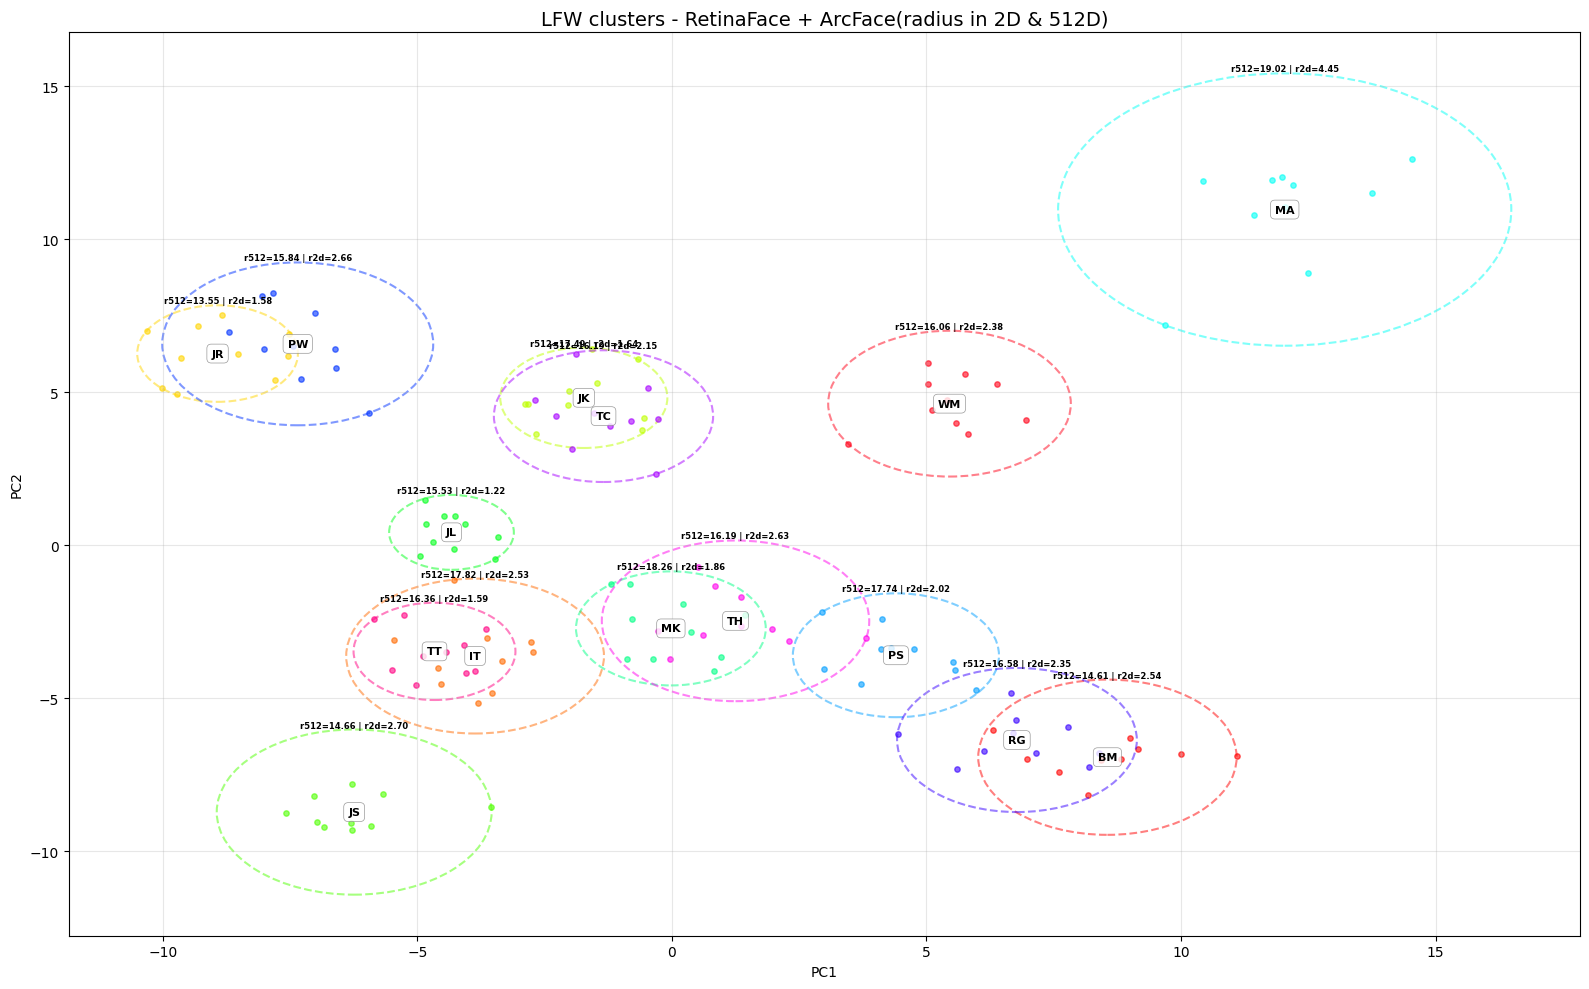

In [114]:
#same figure but with radius circles
plt.figure(figsize=(16, 10))
for idx, lbl in enumerate(np.unique(valid_labels)):
    cluster_points = emb_2d[valid_labels==lbl]
    plt.scatter(cluster_points[:,0], cluster_points[:,1], s=15, alpha=0.6, color=colors[idx])
    identity_name = label_names[lbl]
    centroid_2d = cluster_points.mean(axis=0) #centroid cluster in 2D space

    distances_2d = np.linalg.norm(cluster_points - centroid_2d, axis=1) #max radius in 2D
    radius_2d = distances_2d.max()
    radius_512d = cluster_stats[identity_name]['radius']# radius in original 512D space

    circle = plt.Circle(centroid_2d, radius_2d, color=colors[idx], fill=False, linewidth=1.5, linestyle='--', alpha=0.5) #circle
    plt.gca().add_patch(circle)

    name_parts = identity_name.split()#name initials
    initials = ''.join([part[0].upper() for part in name_parts])
    plt.text(centroid_2d[0], centroid_2d[1], initials, fontsize=8, ha='center', va='center',bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='gray', linewidth=0.5),fontweight='bold')

    #show radius in 512D and 2D PCA
    plt.text(centroid_2d[0], centroid_2d[1] + radius_2d, f'r512={radius_512d:.2f} | r2d={radius_2d:.2f}', fontsize=6, ha='center', va='bottom', color="black", fontweight='bold')

plt.title("LFW clusters - RetinaFace + ArcFace(radius in 2D & 512D)", fontsize=14)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Cosine similarity between clusters

In [115]:
similarities = []
identity_pairs = []

for lbl1, lbl2 in zip(np.unique(valid_labels)[:-1], np.unique(valid_labels)[1:]):
    c1 = cluster_stats[label_names[lbl1]]['centroid']
    c2 = cluster_stats[label_names[lbl2]]['centroid']
    sim = cosine_similarity(c1.reshape(1,-1), c2.reshape(1,-1))[0,0]
    similarities.append(sim)
    identity_pairs.append(f"{label_names[lbl1][:3]} vs {label_names[lbl2][:3]}")
    print(f"Cosine similarity {label_names[lbl1]} vs {label_names[lbl2]}: {sim}")

Cosine similarity Bill McBride vs Ian Thorpe: 0.03181981295347214
Cosine similarity Ian Thorpe vs Jacques Rogge: 0.049021173268556595
Cosine similarity Jacques Rogge vs Jason Kidd: 0.09661569446325302
Cosine similarity Jason Kidd vs Javier Solana: 0.015205287374556065
Cosine similarity Javier Solana vs Jean-David Levitte: -0.0025644637644290924
Cosine similarity Jean-David Levitte vs Mohammad Khatami: -0.02664436586201191
Cosine similarity Mohammad Khatami vs Muhammad Ali: 0.034930519759655
Cosine similarity Muhammad Ali vs Paradorn Srichaphan: 0.02968042716383934
Cosine similarity Paradorn Srichaphan vs Paul Wolfowitz: -0.11496686935424805
Cosine similarity Paul Wolfowitz vs Richard Gere: -0.11222697794437408
Cosine similarity Richard Gere vs Tom Cruise: 0.09774687141180038
Cosine similarity Tom Cruise vs Tom Hanks: 0.0855831652879715
Cosine similarity Tom Hanks vs Tommy Thompson: 0.08316036313772202
Cosine similarity Tommy Thompson vs Walter Mondale: -0.07689718157052994


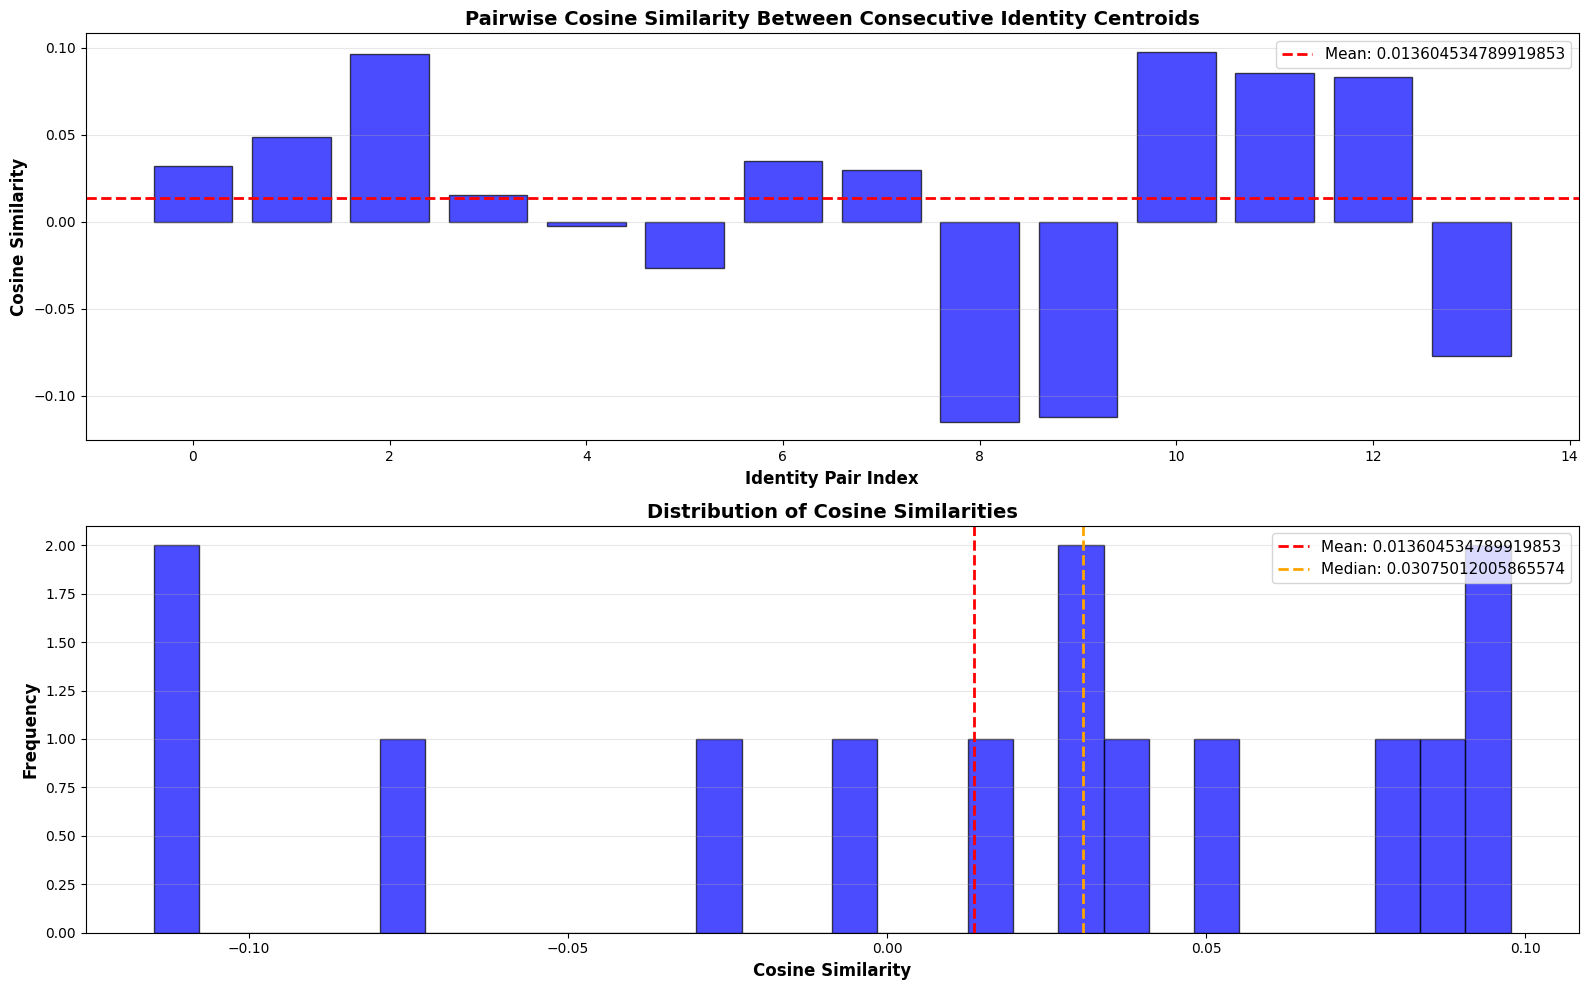

COSINE SIMILARITY STATISTICS (Consecutive Pairs):
Mean similarity: 0.013604534789919853
Median similarity: 0.03075012005865574
Std deviation: 0.07006517052650452
Min similarity: -0.11496686935424805
Max similarity: 0.09774687141180038


In [116]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

#cosine similarities
axes[0].bar(range(len(similarities)), similarities, color='blue', alpha=0.7, edgecolor='black')
axes[0].axhline(y=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[0].set_xlabel('Identity Pair Index', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[0].set_title('Pairwise Cosine Similarity Between Consecutive Identity Centroids', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')
#distribution histogram
axes[1].hist(similarities, bins=30, color='blue', alpha=0.7, edgecolor='black')
axes[1].axvline(x=np.mean(similarities), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(similarities)}')
axes[1].axvline(x=np.median(similarities), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(similarities)}')
axes[1].set_xlabel('Cosine Similarity', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Distribution of Cosine Similarities', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

#stats
print("="*70)
print("COSINE SIMILARITY STATISTICS (Consecutive Pairs):")
print("="*70)
print(f"Mean similarity: {np.mean(similarities)}")
print(f"Median similarity: {np.median(similarities)}")
print(f"Std deviation: {np.std(similarities)}")
print(f"Min similarity: {np.min(similarities)}")
print(f"Max similarity: {np.max(similarities)}")

## 8. Analyze cluster stats

In [117]:
#cluster data to DataFrame
cluster_stats_df = pd.DataFrame.from_dict(cluster_stats, orient='index')
print(cluster_stats_df.head())

                                                        centroid     radius  \
Bill McBride   [-0.35211697, -1.5796963, -1.2840213, -0.46784...  14.606841   
Ian Thorpe     [-0.48320422, 0.74765456, 0.32357216, -1.08414...  17.824362   
Jacques Rogge  [0.2698771, 0.5046526, 0.26977342, -1.5241728,...  13.552886   
Jason Kidd     [-1.1222484, -0.082160175, 0.30334848, 0.17638...  17.493803   
Javier Solana  [0.5826578, 0.09006043, 0.60530204, -0.1212996...  14.663967   

               dispersion  num_images  
Bill McBride     1.143184          10  
Ian Thorpe       1.556368          10  
Jacques Rogge    1.280454          10  
Jason Kidd       1.896501          10  
Javier Solana    1.079403          10  


In [118]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
merged_df = intrinsic_dim_df.merge(cluster_stats_df, left_index=True, right_index=True)
print("Merged DataFrame created successfully")
print(merged_df.head())

Merged DataFrame created successfully
               intrinsic_dimension  \
Bill McBride                     9   
Ian Thorpe                       9   
Jacques Rogge                    9   
Jason Kidd                       9   
Javier Solana                    9   

                                                        centroid     radius  \
Bill McBride   [-0.35211697, -1.5796963, -1.2840213, -0.46784...  14.606841   
Ian Thorpe     [-0.48320422, 0.74765456, 0.32357216, -1.08414...  17.824362   
Jacques Rogge  [0.2698771, 0.5046526, 0.26977342, -1.5241728,...  13.552886   
Jason Kidd     [-1.1222484, -0.082160175, 0.30334848, 0.17638...  17.493803   
Javier Solana  [0.5826578, 0.09006043, 0.60530204, -0.1212996...  14.663967   

               dispersion  num_images  
Bill McBride     1.143184          10  
Ian Thorpe       1.556368          10  
Jacques Rogge    1.280454          10  
Jason Kidd       1.896501          10  
Javier Solana    1.079403          10  


In [119]:
print("Summary Statistics for Merged DataFrame:")
print(merged_df[['intrinsic_dimension', 'radius', 'dispersion', 'num_images']].describe())

Summary Statistics for Merged DataFrame:
       intrinsic_dimension     radius  dispersion  num_images
count                 15.0  15.000000   15.000000        15.0
mean                   9.0  16.393906    1.523483        10.0
std                    0.0   1.486712    0.272863         0.0
min                    9.0  13.552886    1.079403        10.0
25%                    9.0  15.685998    1.345187        10.0
50%                    9.0  16.191816    1.496322        10.0
75%                    9.0  17.615906    1.787171        10.0
max                    9.0  19.016243    1.922117        10.0


In [120]:
print("\nIdentities with most consistent face embeddings (smallest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=True).head())

print("\nIdentities with least consistent face embeddings (largest radius):")
print(cluster_stats_df.sort_values(by='radius', ascending=False).head())

print("\nIdentities with least dispersed embeddings (smallest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=True).head())

print("\nIdentities with most dispersed embeddings (largest dispersion):")
print(cluster_stats_df.sort_values(by='dispersion', ascending=False).head())

print("\nIndividuals with the most images:")
print(cluster_stats_df.sort_values(by='num_images', ascending=False).head())


Identities with most consistent face embeddings (smallest radius):
                                                             centroid  \
Jacques Rogge       [0.2698771, 0.5046526, 0.26977342, -1.5241728,...   
Bill McBride        [-0.35211697, -1.5796963, -1.2840213, -0.46784...   
Javier Solana       [0.5826578, 0.09006043, 0.60530204, -0.1212996...   
Jean-David Levitte  [0.35058436, -1.0723407, 0.5212992, 0.08375201...   
Paul Wolfowitz      [-0.3278905, -0.37722883, 0.2769836, 0.0764784...   

                       radius  dispersion  num_images  
Jacques Rogge       13.552886    1.280454          10  
Bill McBride        14.606841    1.143184          10  
Javier Solana       14.663967    1.079403          10  
Jean-David Levitte  15.530003    1.409919          10  
Paul Wolfowitz      15.841994    1.425003          10  

Identities with least consistent face embeddings (largest radius):
                                                              centroid  \
Muhammad Ali   

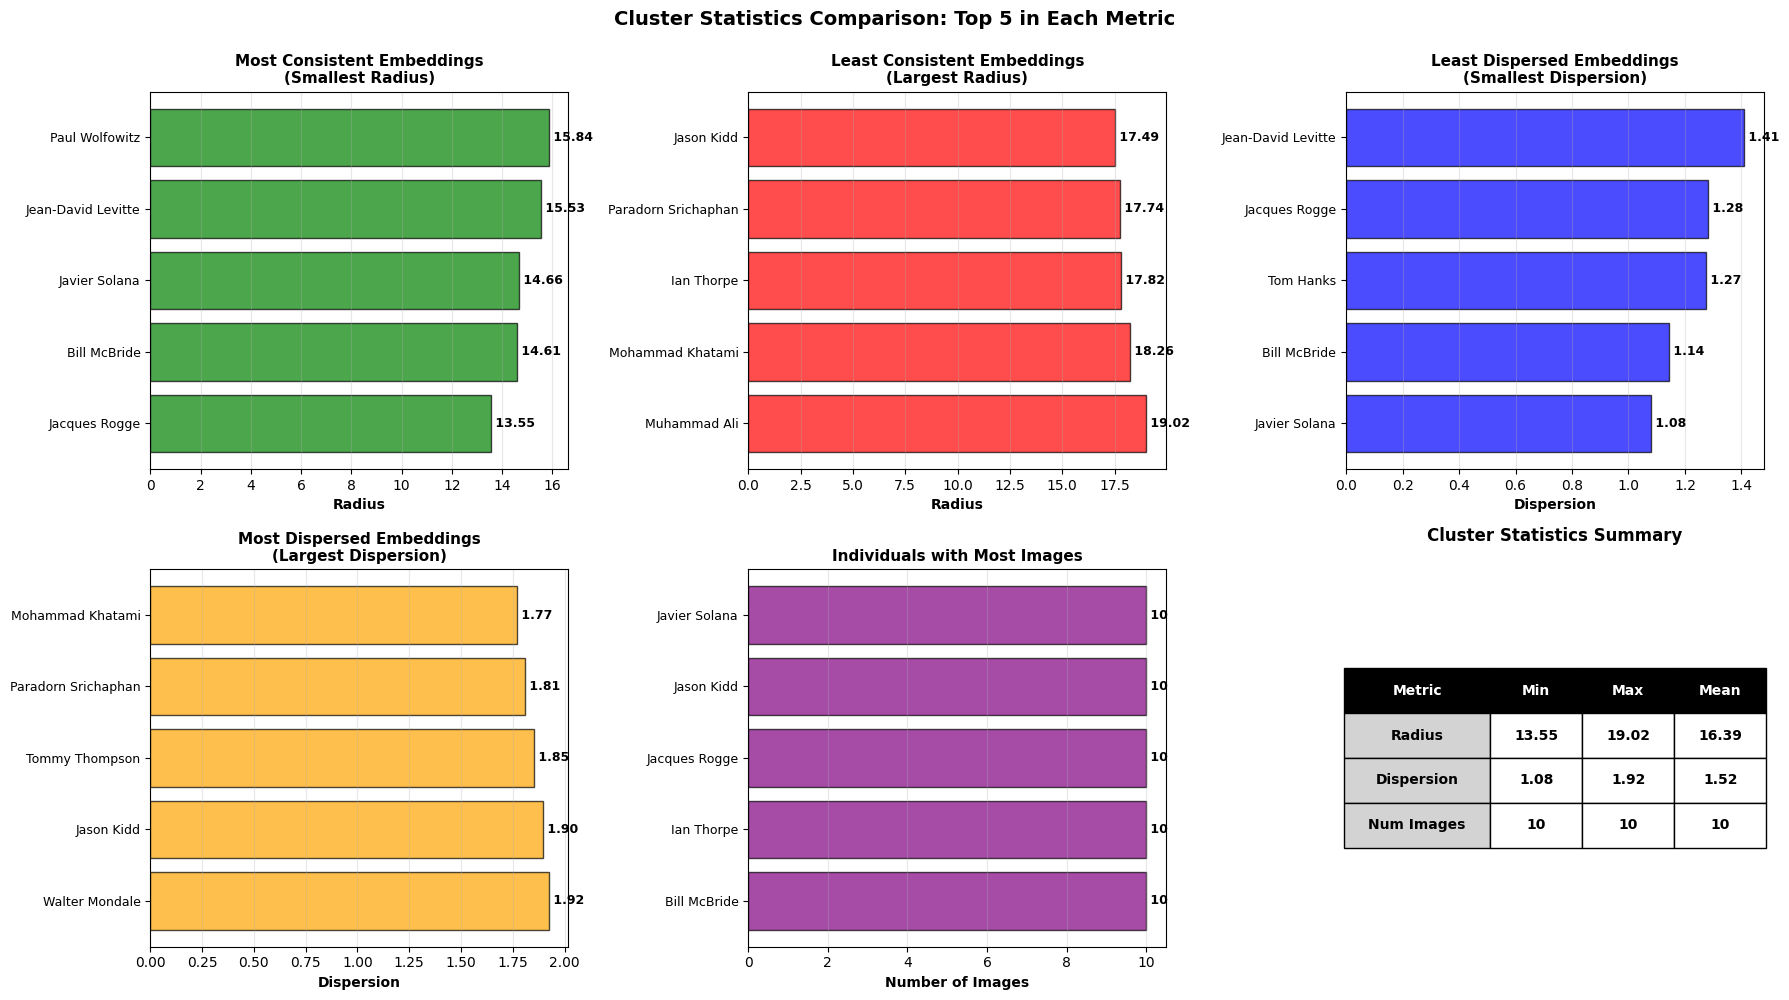

In [121]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#smallest radius (most consistent)
smallest_radius = cluster_stats_df.sort_values(by='radius', ascending=True).head()
axes[0, 0].barh(range(len(smallest_radius)), smallest_radius['radius'], color='green', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(smallest_radius)))
axes[0, 0].set_yticklabels(smallest_radius.index, fontsize=9)
axes[0, 0].set_xlabel('Radius', fontweight='bold')
axes[0, 0].set_title('Most Consistent Embeddings\n(Smallest Radius)', fontweight='bold', fontsize=11)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_radius['radius']):
    axes[0, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest radius (least consistent)
largest_radius = cluster_stats_df.sort_values(by='radius', ascending=False).head()
axes[0, 1].barh(range(len(largest_radius)), largest_radius['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(largest_radius)))
axes[0, 1].set_yticklabels(largest_radius.index, fontsize=9)
axes[0, 1].set_xlabel('Radius', fontweight='bold')
axes[0, 1].set_title('Least Consistent Embeddings\n(Largest Radius)', fontweight='bold', fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_radius['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#smallest dispersion
smallest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=True).head()
axes[0, 2].barh(range(len(smallest_dispersion)), smallest_dispersion['dispersion'], color='blue', alpha=0.7, edgecolor='black')
axes[0, 2].set_yticks(range(len(smallest_dispersion)))
axes[0, 2].set_yticklabels(smallest_dispersion.index, fontsize=9)
axes[0, 2].set_xlabel('Dispersion', fontweight='bold')
axes[0, 2].set_title('Least Dispersed Embeddings\n(Smallest Dispersion)', fontweight='bold', fontsize=11)
axes[0, 2].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(smallest_dispersion['dispersion']):
    axes[0, 2].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#largest dispersion
largest_dispersion = cluster_stats_df.sort_values(by='dispersion', ascending=False).head()
axes[1, 0].barh(range(len(largest_dispersion)), largest_dispersion['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(largest_dispersion)))
axes[1, 0].set_yticklabels(largest_dispersion.index, fontsize=9)
axes[1, 0].set_xlabel('Dispersion', fontweight='bold')
axes[1, 0].set_title('Most Dispersed Embeddings\n(Largest Dispersion)', fontweight='bold', fontsize=11)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(largest_dispersion['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#images
most_images = cluster_stats_df.sort_values(by='num_images', ascending=False).head()
axes[1, 1].barh(range(len(most_images)), most_images['num_images'], color='purple', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(most_images)))
axes[1, 1].set_yticklabels(most_images.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Individuals with Most Images', fontweight='bold', fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(most_images['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#statistics table
axes[1, 2].axis('tight')
axes[1, 2].axis('off')
summary_data = [
    ['Metric', 'Min', 'Max', 'Mean'],
    ['Radius', f"{cluster_stats_df['radius'].min():.2f}", f"{cluster_stats_df['radius'].max():.2f}", f"{cluster_stats_df['radius'].mean():.2f}"],
    ['Dispersion', f"{cluster_stats_df['dispersion'].min():.2f}", f"{cluster_stats_df['dispersion'].max():.2f}", f"{cluster_stats_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(cluster_stats_df['num_images'].min())}", f"{int(cluster_stats_df['num_images'].max())}", f"{int(cluster_stats_df['num_images'].mean())}"]
]
table = axes[1, 2].table(cellText=summary_data, cellLoc='center', loc='center', colWidths=[0.35, 0.22, 0.22, 0.22])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)
for i in range(4): #header
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4): #rows
    table[(i, 0)].set_facecolor('#D3D3D3')
    table[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table[(i, j)].set_facecolor('white' if i % 2 == 0 else 'white')
        table[(i, j)].set_text_props(weight='bold')
axes[1, 2].set_title('Cluster Statistics Summary', fontweight='bold', fontsize=12, pad=20)

plt.suptitle('Cluster Statistics Comparison: Top 5 in Each Metric', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

- **Smallest Radius:** small average distance of ther embeddings from their centroids = face embeddings are tightly clustered, so they have higher consistency across different imgs of the same person
- **Largest Radius:** largest average distance from their centroids. Face embeddings are more spread out, so they have less consistency or greater variation in their imgs
- **Smallest Dispersion:** so small deviation of distances from their centroids, so the variation in embedding consistency are very low
- **Largest Dispersion:** largest deviation of distances, so they have more variability in the consistency of their embeddings. High dispersion = wider range of conditions in the imgs (pose, light, expression...)
- **Most Images:** lead to larger radii or dispersion due to greater diversity

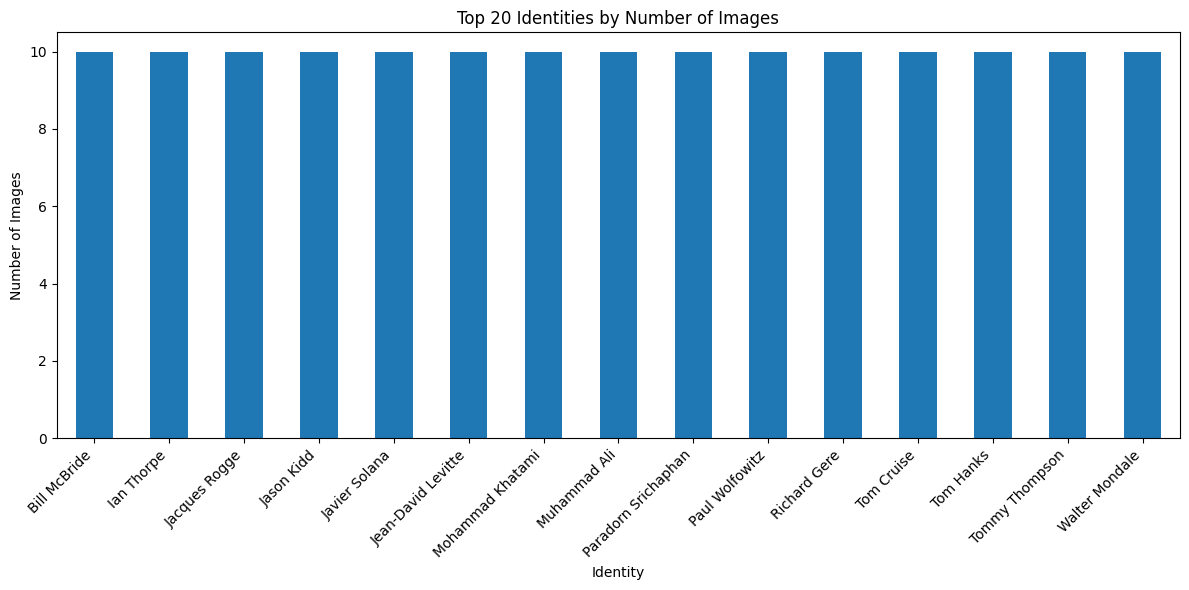

In [122]:
# number of imgs per identity bar plot
plt.figure(figsize=(12, 6))
top_n = 20  # Display top 20 identities
cluster_stats_df.sort_values(by='num_images', ascending=False).head(top_n)['num_images'].plot(kind='bar')
plt.title(f'Top {top_n} Identities by Number of Images')
plt.xlabel('Identity')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 9. Scatter Plot: Intrinsic Dimension vs. Cluster Dispersion

Higher intrinsic complexity in a person's image set often correlates with greater variability in the consistency of their face embeddings. The ArcFace model, while robust, shows signs of this increased challenge through higher dispersion values for identities with higher intrinsic dimensions.

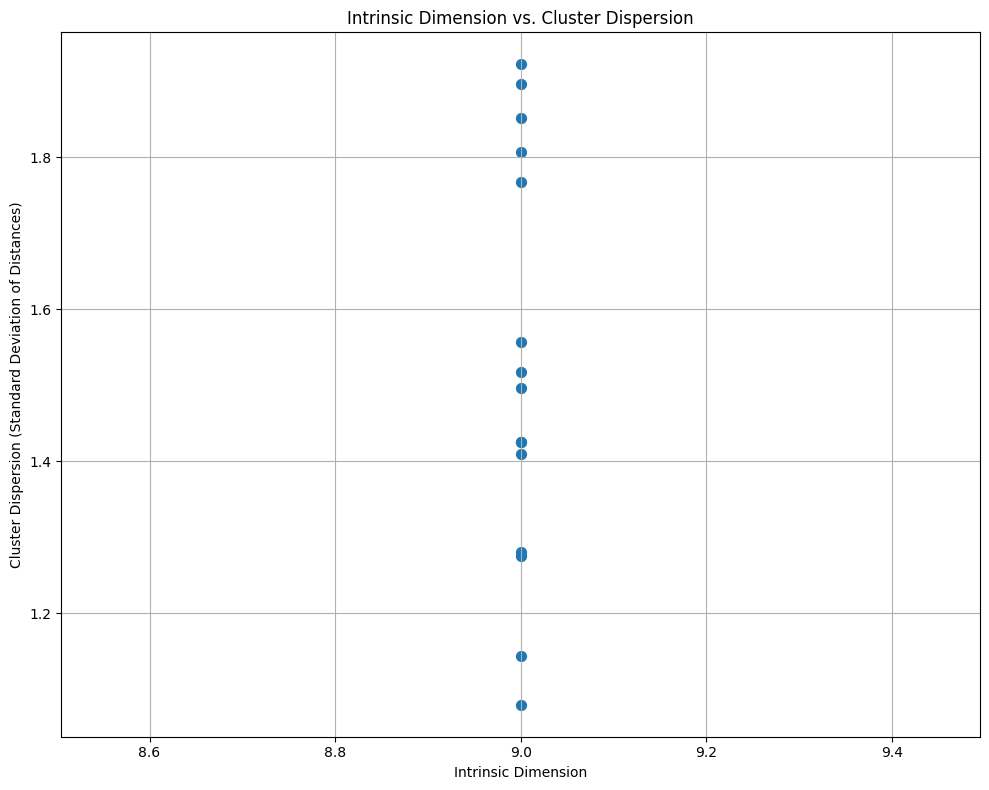

In [123]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['intrinsic_dimension'], merged_df['dispersion'], s=50)
plt.title('Intrinsic Dimension vs. Cluster Dispersion')
plt.xlabel('Intrinsic Dimension')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 10. Scatter Plot: Radius vs Dispersion


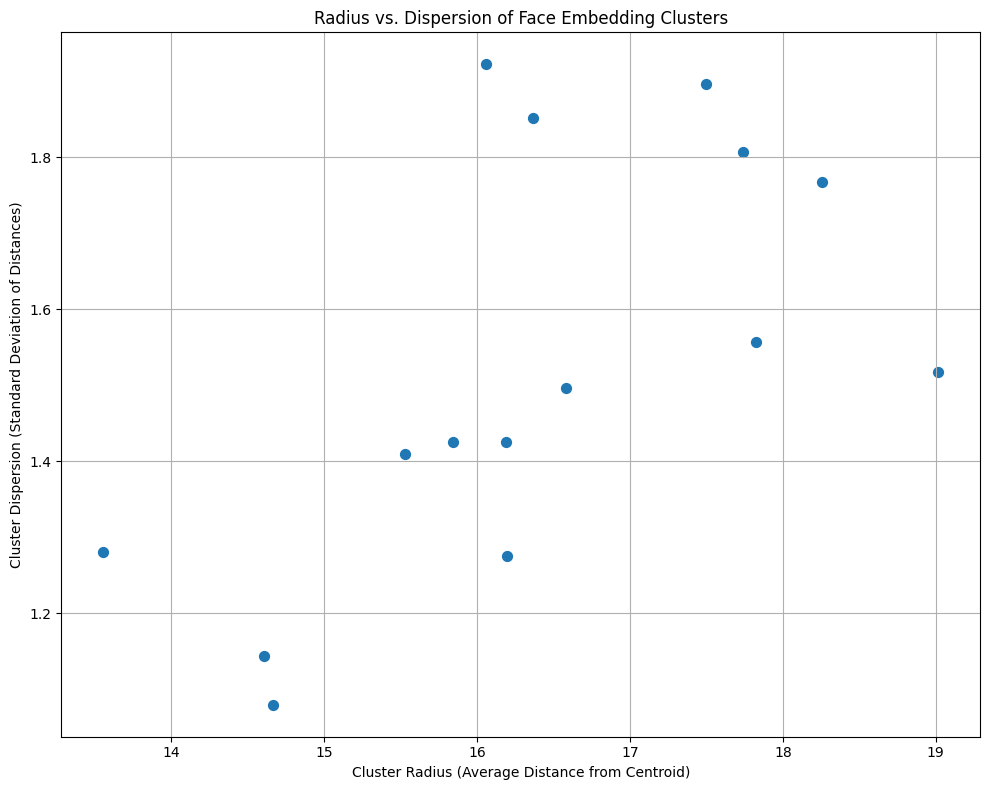

In [124]:
plt.figure(figsize=(10, 8))
plt.scatter(cluster_stats_df['radius'], cluster_stats_df['dispersion'], s=50)
plt.title('Radius vs. Dispersion of Face Embedding Clusters')
plt.xlabel('Cluster Radius (Average Distance from Centroid)')
plt.ylabel('Cluster Dispersion (Standard Deviation of Distances)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 11. Intrinsic Dimension of Clusters


In [125]:
intrinsic_dim_df = pd.DataFrame.from_dict(intrinsic_dim, orient='index', columns=['intrinsic_dimension'])
print("Intrinsic Dimensionality DataFrame Head:")
print(intrinsic_dim_df.head())

Intrinsic Dimensionality DataFrame Head:
               intrinsic_dimension
Bill McBride                     9
Ian Thorpe                       9
Jacques Rogge                    9
Jason Kidd                       9
Javier Solana                    9


In [126]:
print("\nDescriptive Statistics for Intrinsic Dimensionality:")
print(intrinsic_dim_df['intrinsic_dimension'].describe())

print("\nIdentities with the 10 highest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=False).head(10))

print("\nIdentities with the 10 lowest intrinsic dimensions:")
print(intrinsic_dim_df.sort_values(by='intrinsic_dimension', ascending=True).head(10))


Descriptive Statistics for Intrinsic Dimensionality:
count    15.0
mean      9.0
std       0.0
min       9.0
25%       9.0
50%       9.0
75%       9.0
max       9.0
Name: intrinsic_dimension, dtype: float64

Identities with the 10 highest intrinsic dimensions:
                     intrinsic_dimension
Bill McBride                           9
Ian Thorpe                             9
Jacques Rogge                          9
Jason Kidd                             9
Javier Solana                          9
Jean-David Levitte                     9
Mohammad Khatami                       9
Muhammad Ali                           9
Paradorn Srichaphan                    9
Paul Wolfowitz                         9

Identities with the 10 lowest intrinsic dimensions:
                     intrinsic_dimension
Bill McBride                           9
Ian Thorpe                             9
Jacques Rogge                          9
Jason Kidd                             9
Javier Solana                


### Identities with High Intrinsic Dimensionality
exhibit a greater complexity or variability. This means that more principal components are needed to explain the variance within their respective clusters. This could be due to a wider range of poses, expressions, lighting conditions, or even image quality variations for these individuals in the LFW dataset.

### Identities with Low Intrinsic Dimensionality
their image clusters are less complex or more consistent. Fewer principal components are sufficient to capture the variance within their embeddings. This might imply that the images for these individuals are more uniform in terms of visual characteristics, or perhaps their facial features are inherently less variable across different images presented to the model.

In [127]:
top_10_high_intrinsic_dim_identities = intrinsic_dim_df.nlargest(10, 'intrinsic_dimension')
top_10_data = merged_df.loc[top_10_high_intrinsic_dim_identities.index][['intrinsic_dimension', 'radius', 'dispersion', 'num_images']]
print("\nMetrics for Identities with the 10 Highest Intrinsic Dimensions:")
print(top_10_data)


Metrics for Identities with the 10 Highest Intrinsic Dimensions:
                     intrinsic_dimension     radius  dispersion  num_images
Bill McBride                           9  14.606841    1.143184          10
Ian Thorpe                             9  17.824362    1.556368          10
Jacques Rogge                          9  13.552886    1.280454          10
Jason Kidd                             9  17.493803    1.896501          10
Javier Solana                          9  14.663967    1.079403          10
Jean-David Levitte                     9  15.530003    1.409919          10
Mohammad Khatami                       9  18.255651    1.767737          10
Muhammad Ali                           9  19.016243    1.517158          10
Paradorn Srichaphan                    9  17.738008    1.806606          10
Paul Wolfowitz                         9  15.841994    1.425003          10


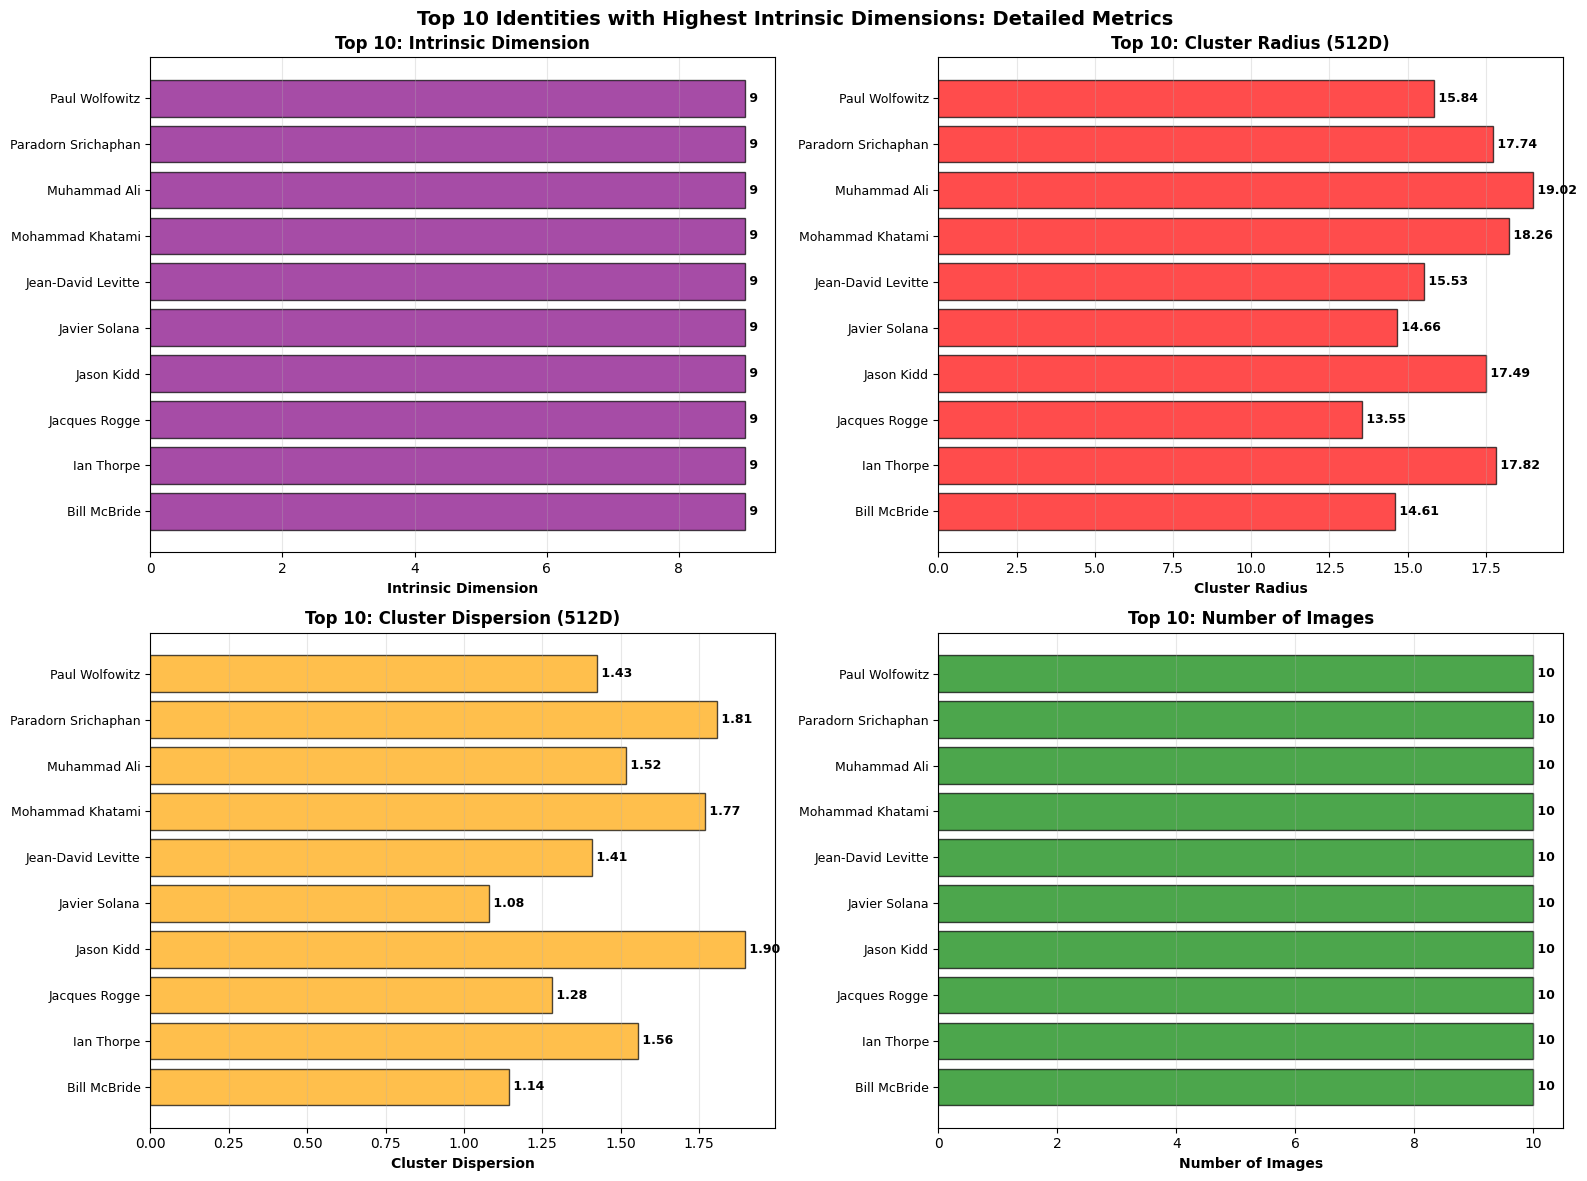

In [128]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

#intrinsic Dimension
axes[0, 0].barh(range(len(top_10_data)), top_10_data['intrinsic_dimension'], color='purple', alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(top_10_data)))
axes[0, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 0].set_xlabel('Intrinsic Dimension', fontweight='bold')
axes[0, 0].set_title('Top 10: Intrinsic Dimension', fontweight='bold', fontsize=12)
axes[0, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['intrinsic_dimension']):
    axes[0, 0].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

#radius
axes[0, 1].barh(range(len(top_10_data)), top_10_data['radius'], color='red', alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(top_10_data)))
axes[0, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[0, 1].set_xlabel('Cluster Radius', fontweight='bold')
axes[0, 1].set_title('Top 10: Cluster Radius (512D)', fontweight='bold', fontsize=12)
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['radius']):
    axes[0, 1].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#dispersion
axes[1, 0].barh(range(len(top_10_data)), top_10_data['dispersion'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_yticks(range(len(top_10_data)))
axes[1, 0].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 0].set_xlabel('Cluster Dispersion', fontweight='bold')
axes[1, 0].set_title('Top 10: Cluster Dispersion (512D)', fontweight='bold', fontsize=12)
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['dispersion']):
    axes[1, 0].text(val, i, f' {val:.2f}', va='center', fontweight='bold', fontsize=9)

#number of Images
axes[1, 1].barh(range(len(top_10_data)), top_10_data['num_images'], color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_10_data)))
axes[1, 1].set_yticklabels(top_10_data.index, fontsize=9)
axes[1, 1].set_xlabel('Number of Images', fontweight='bold')
axes[1, 1].set_title('Top 10: Number of Images', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, val in enumerate(top_10_data['num_images']):
    axes[1, 1].text(val, i, f' {int(val)}', va='center', fontweight='bold', fontsize=9)

plt.suptitle('Top 10 Identities with Highest Intrinsic Dimensions: Detailed Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

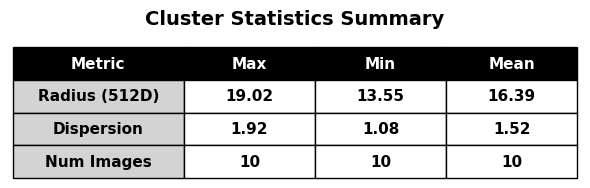

In [129]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('tight')
ax.axis('off')
summary_table_data = [
    ['Metric', 'Max', 'Min', 'Mean'],
    ['Radius (512D)', f"{merged_df['radius'].max():.2f}", f"{merged_df['radius'].min():.2f}", f"{merged_df['radius'].mean():.2f}"],
    ['Dispersion', f"{merged_df['dispersion'].max():.2f}", f"{merged_df['dispersion'].min():.2f}", f"{merged_df['dispersion'].mean():.2f}"],
    ['Num Images', f"{int(merged_df['num_images'].max())}", f"{int(merged_df['num_images'].min())}", f"{int(merged_df['num_images'].mean())}"]
]
table1 = ax.table(cellText=summary_table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.23, 0.23, 0.23])
table1.auto_set_font_size(False)
table1.set_fontsize(11)
table1.scale(1, 2.5)
for i in range(4):
    table1[(0, i)].set_facecolor('black')
    table1[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, 4):
    table1[(i, 0)].set_facecolor('#D3D3D3')
    table1[(i, 0)].set_text_props(weight='bold')
    for j in range(1, 4):
        table1[(i, j)].set_facecolor('white')
        table1[(i, j)].set_text_props(weight='bold')
plt.title('Cluster Statistics Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

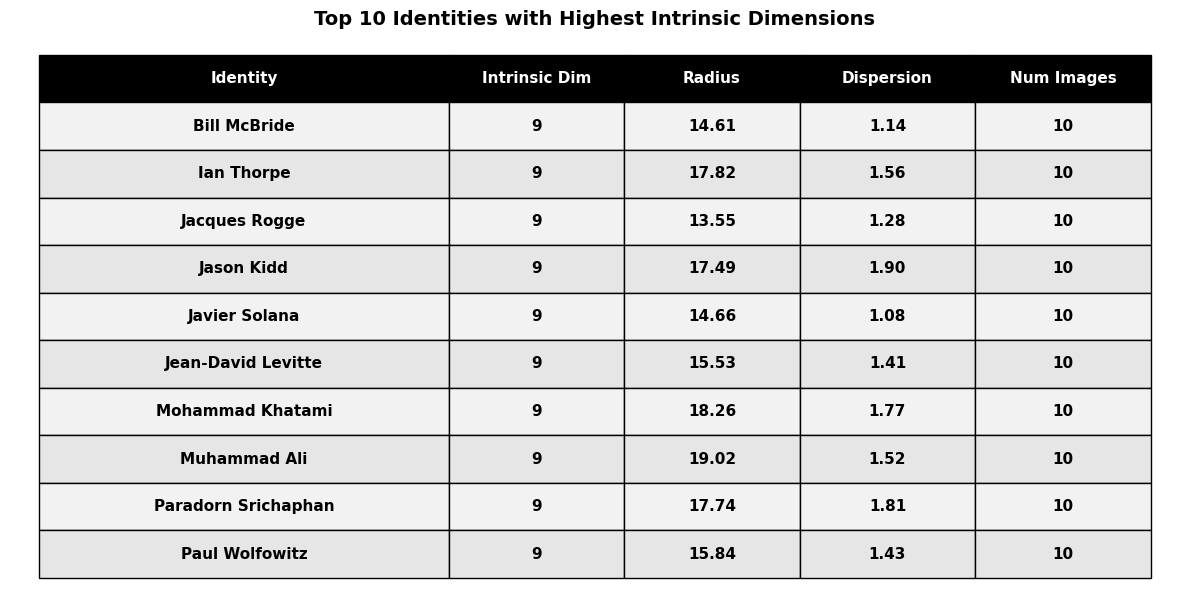

In [130]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.axis('tight')
ax.axis('off')
table_data = [['Identity', 'Intrinsic Dim', 'Radius', 'Dispersion', 'Num Images']]
for identity, row in top_10_data.iterrows():
    table_data.append([
        identity,
        f"{int(row['intrinsic_dimension'])}",
        f"{row['radius']:.2f}",
        f"{row['dispersion']:.2f}",
        f"{int(row['num_images'])}"
    ])
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.35, 0.15, 0.15, 0.15, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

for i in range(5):
    table[(0, i)].set_facecolor('black')
    table[(0, i)].set_text_props(weight='bold', color='white')
for i in range(1, len(table_data)):
    for j in range(5):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#E7E6E6')
        else:
            table[(i, j)].set_facecolor('#F2F2F2')
        table[(i, j)].set_text_props(weight='bold')
plt.title('Top 10 Identities with Highest Intrinsic Dimensions', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## 12. Scatter Plot: Radius and Number of Images


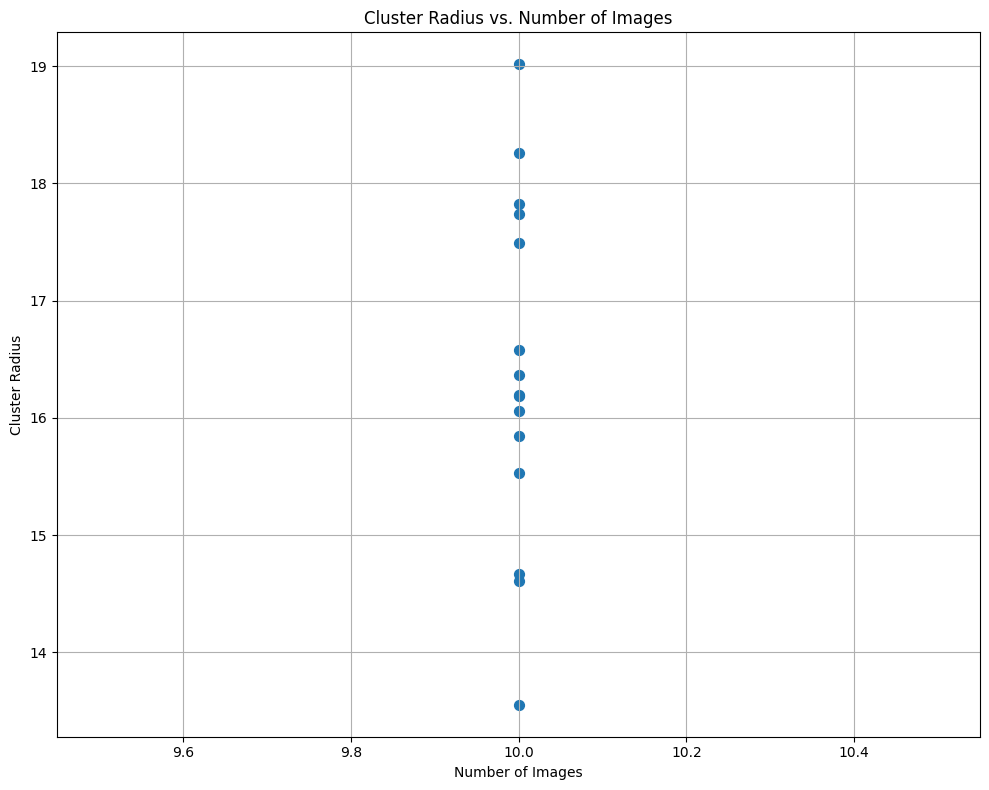

In [131]:
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['num_images'], merged_df['radius'], s=50)
plt.title('Cluster Radius vs. Number of Images')
plt.xlabel('Number of Images')
plt.ylabel('Cluster Radius')
plt.grid(True)
plt.tight_layout()
plt.show()

No strong linear correlation between them


Even with few images some identites have very consistent embeddings, while others can be quite incosistent

